In [15]:
import torch
import torch.nn as nn
from torch_geometric.datasets import QM9
import numpy as np
from torch.utils.data import random_split
# import jax
import matplotlib.pyplot as plt
import os

In [16]:
qm9 = QM9(os.path.join(os.getcwd(), 'qm9_data'))

In [17]:
for d in qm9:
    print (d)
    print(d.z)
    print(d.pos)
    break


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], name='gdb_1', idx=[1])
tensor([6, 1, 1, 1, 1])
tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
        [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
        [ 1.0117e+00,  1.4638e+00,  3.0000e-04],
        [-5.4080e-01,  1.4475e+00, -8.7660e-01],
        [-5.2380e-01,  1.4379e+00,  9.0640e-01]])


Preprocess the Data

In [18]:
# Now we will do some processing of the data to get into a more usable format. 
# Let’s convert to numpy arrays, remove the partial charges, and convert the elements into one-hot vectors.
def convert_record(d):
    # elements
    e = d.z #.numpy()
    # xyz position
    x = d.pos.numpy() # das hier ist Numpy aber wird später zu tensor (bei x2e)
    # target 
    y = d.y[0][7]

    # make ohc size larger
    # so use same node feature
    # shape later
    ohc = np.zeros((len(e), 16))
    ohc[np.arange(len(e)), e - 1] = 1
    ohc_tensor = torch.from_numpy(ohc)
    return (ohc_tensor, x), y

for d in qm9:
    (e, x), y = convert_record(d)
    print("Element one hots: \n", e)
    print("tensor size of elements: ", e.size()[0])
    print("Coordinates: \n", x)
    print("Label:", y)
    break

Element one hots: 
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
tensor size of elements:  5
Coordinates: 
 [[-1.2700e-02  1.0858e+00  8.0000e-03]
 [ 2.2000e-03 -6.0000e-03  2.0000e-03]
 [ 1.0117e+00  1.4638e+00  3.0000e-04]
 [-5.4080e-01  1.4475e+00 -8.7660e-01]
 [-5.2380e-01  1.4379e+00  9.0640e-01]]
Label: tensor(-1101.4878)


Get training and test and validation data

In [19]:
dataset = torch.utils.data.random_split(qm9, [0.05,0.01,0.01,0.93])
training_set = dataset[0]
test_set = dataset[1]
validation_set = dataset[2]
# dataset[3] = all remaining data

The labels in this data are quite large, so we’re going to make a transform on them to make
our learning rates and training going more smoothly.

In [20]:
ys = [convert_record(d)[1] for d in training_set]
train_ym = np.mean(ys)
train_ys = np.std(ys)
print("Mean = ", train_ym, "Std =", train_ys)


def transform_label(y):
    return (y - train_ym) / train_ys


def transform_prediction(y):
    return y * train_ys + train_ym

Mean =  -11183.437 Std = 1095.5818


Convert xyz coordinates to inverse pairwise distance.
The choice of pairwise distance gives us translation and rotation invariance.
The choice of inverse distance means that atoms which are far away naturally have low edge weights.

In [21]:
def x2e(x):
    """convert xyz coordinates to inverse pairwise distance"""
    r2 = np.sum((x - x[:, np.newaxis, :]) ** 2, axis=-1)
    e = np.where(r2 != 0, 1 / r2, 0.0)
    e = torch.from_numpy(e).double()
    return e

print(x2e(x))

tensor([[0.0000, 0.8387, 0.8387, 0.8388, 0.8387],
        [0.8387, 0.0000, 0.3145, 0.3145, 0.3145],
        [0.8387, 0.3145, 0.0000, 0.3145, 0.3145],
        [0.8388, 0.3145, 0.3145, 0.0000, 0.3145],
        [0.8387, 0.3145, 0.3145, 0.3145, 0.0000]], dtype=torch.float64)


C:\Users\rotht\AppData\Local\Temp/ipykernel_23332/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


Implementation of the GNN Layer

In [22]:
def gnn_layer(nodes, edges, features, we, wb, wv, wu):
    """ Implementation of the GNN
    make nodes be N x N so we can just multiply directly
    ek is now shaped N x N x features """

    # ek = jax.nn.leaky_relu(web + jnp.repeat(nodes[jnp.newaxis, ...], nodes.shape[0], axis=0) @ we * edges[..., jnp.newaxis]
    leaky_relu = torch.nn.LeakyReLU(0.01)
    new_nodes_tensor = torch.repeat_interleave(nodes[None, :], nodes.size()[0], dim=0)
    input_tensor = wb + torch.matmul(new_nodes_tensor ,we) * torch.transpose(edges[:,None],1,2)
    ek = leaky_relu(input_tensor)

    # sum over neighbors to get N x features
    # ebar = jnp.sum(ek, axis=1)
    ebar = torch.sum(ek, 1)

    # dense layer for new nodes to get N x features
    # new_nodes = jax.nn.leaky_relu(ebar @ wv) + nodes
    new_nodes = leaky_relu(torch.matmul(ebar, wv) + nodes)

    # sum over nodes to get shape features
    # global_node_features = jnp.sum(new_nodes, axis=0)   
    global_node_features = torch.sum(new_nodes,0)    

    # dense layer for new features
    # new_features = jax.nn.leaky_relu(global_node_features @ wu) + features
    new_features = leaky_relu(torch.matmul(global_node_features, wu)) + features

    # just return features for ease of use
    return new_nodes, edges, new_features

We have implemented the code to convert coordinates into inverse pairwise distance and the GNN equations above. 
Let’s test them out.

In [23]:
graph_feature_len = 8
node_feature_len = 16
msg_feature_len = 16

# make our weights as tensors
def init_weights(g, n, m):
    # originally
    # we = np.random.normal(size=(n, m), scale=1e-1)
    # wb = np.random.normal(size=(m), scale=1e-1)
    # wv = np.random.normal(size=(m, n), scale=1e-1)
    # wu = np.random.normal(size=(n, g), scale=1e-1)

    # additionally
    # we = torch.tensor(we).double()
    # we = torch.autograd.Variable(we, requires_grad=True)
    # dann muss ich das obere (originally) weglassen! Und danach randomly die Variable initialisieren
    we = torch.nn.Parameter(data=torch.Tensor(n,m).double(), requires_grad=True) 
    we.data.normal_(0,1e-1)
    # print("we is a leaf? ", we.is_leaf)
    # we = we.double()
    # we = we.type(torch.DoubleTensor)
    # wb = torch.tensor(wb).double()
    # wb = torch.autograd.Variable(wb, requires_grad=True)
    wb = torch.nn.Parameter(data=torch.Tensor(m).double(), requires_grad=True) 
    wb.data.normal_(0,1e-1)
    # print("wb is a leaf? ", wb.is_leaf)
    # wb = wb.double()
    # wb = wb.type(torch.DoubleTensor)
    # wv = torch.tensor(wv).double()
    # wv = torch.autograd.Variable(wv, requires_grad=True)
    wv = torch.nn.Parameter(data=torch.Tensor(m,n).double(), requires_grad=True) 
    wv.data.normal_(0,1e-1)
    # print("wv is a leaf? ", wv.is_leaf)
    # wv = wv.double()
    # wv = wv.type(torch.DoubleTensor)
    # wu = torch.tensor(wu).double()
    # wu = torch.autograd.Variable(wu, requires_grad=True)
    wu = torch.nn.Parameter(data=torch.Tensor(n,g).double(), requires_grad=True) 
    wu.data.normal_(0,1e-1)
    # print("wu is a leaf? ", wu.is_leaf)
    # wu = wu.double()
    # wu = wu.type(torch.DoubleTensor)
    
    return [we, wb, wv, wu]

# make a graph
nodes = e
edges = x2e(x)
features = np.zeros(graph_feature_len)
features = torch.from_numpy(features).double()

print("nodes: \n", nodes)
print("edges: \n", edges)
print("features: \n", features)

# eval
weights = init_weights(graph_feature_len, node_feature_len, msg_feature_len)
out = gnn_layer(nodes, edges, features, *weights)

# print("weights: \n", weights)
print("input feautres: \n", features)
print("output features: \n", out[2])

nodes: 
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
edges: 
 tensor([[0.0000, 0.8387, 0.8387, 0.8388, 0.8387],
        [0.8387, 0.0000, 0.3145, 0.3145, 0.3145],
        [0.8387, 0.3145, 0.0000, 0.3145, 0.3145],
        [0.8388, 0.3145, 0.3145, 0.0000, 0.3145],
        [0.8387, 0.3145, 0.3145, 0.3145, 0.0000]], dtype=torch.float64)
features: 
 tensor([0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
input feautres: 
 tensor([0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
output features: 
 tensor([-0.0011,  0.6079, -0.0061, -0.0011,  0.4372, -0.0040,  0.2599,  0.2088],
       dtype=torch.float64, grad_fn=<AddBackward0>)


C:\Users\rotht\AppData\Local\Temp/ipykernel_23332/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


Great! Our model can update the graph features.
Now we need to convert this into callable and loss. We’ll stack two GNN layers.

In [24]:
# get weights for both layers
w1 = init_weights(graph_feature_len, node_feature_len, msg_feature_len)
w2 = init_weights(graph_feature_len, node_feature_len, msg_feature_len) #! ausprobieren, kann sein, dass Variablen überschrieben werden!!!
[we1, wb1, wv1, wu1] = w1
[we2, wb2, wv2, wu2] = w2

# print("w1: ", w1)
# print("w2: ", w2)
# w3 = np.random.normal(size=(graph_feature_len))
# b = 0.0
# w3 und b müssen als tensor definiert werden!
# w3 = torch.rand((graph_feature_len)).double()
# definiere w3 so wie oben!

w3 = torch.nn.Parameter(data=torch.Tensor(graph_feature_len).double(), requires_grad=True)
w3.data.normal_(0,1)

# w3.double()
# w3 = w3.type(torch.DoubleTensor)
# print("w3 is a leaf?", w3.is_leaf)

# offensichtlich braucht man torch.autograd, sonst kommt None Type raus
# w3 = torch.autograd.Variable(w3, requires_grad=True)
# b = torch.tensor(0.).double()
# b = torch.autograd.Variable(b, requires_grad=True)

b = torch.nn.Parameter(data=torch.zeros(1).double(), requires_grad=True) # b wird mit einer Null initialisiert

#b = b.double()
# print("b is a leaf?", b.is_leaf)

# # # * * * OLD VERSION * * * # # #:

# def model(nodes, coords, w1, w2, w3, b):
#     # f0 = jnp.zeros(graph_feature_len)
#     f0 = torch.from_numpy(np.zeros(graph_feature_len)).double()
#     e0 = x2e(coords)
#     n0 = nodes
#     n1, e1, f1 = gnn_layer(n0, e0, f0, *w1)
#     n2, e2, f2 = gnn_layer(n1, e1, f1, *w2)
#     # yhat = f2 @ w3 + b
#     yhat = torch.matmul(f2, w3) + b
#     return yhat


# Now we do the same with the nn.Module class so that we are able to save it
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
class Model(nn.Module):
    # funktion für initialisierung hier einbauen

    def __init__(self, w1, w2, w3, b, graph_feature_len): # hier argumente für die layer
        # Gewichte werden hier initialisiert !!! Nicht übergeben
        # hier kann ich gnn_layer klasse aufrufen!
        # self.gnn_layer = # instanz initialisieren
        super(Model, self).__init__()
        self.w1= w1
        self.w2 = w2
        self.w3 = w3
        self.b = b
        self.graph_feature_len = graph_feature_len

    # hier muss ich auch die trainable parameter definieren in der init funktion
    # wo ich beim backward pass den gradienten bilden muss
    # werden geupdated mit optimizer Schritt
    def gnn_layer(self, nodes, edges, features, we, wb, wv, wu): # separate Klasse die auch von nn.module erbt!
        """ Implementation of the GNN
        make nodes be N x N so we can just multiply directly
        ek is now shaped N x N x features """
        # ek = jax.nn.leaky_relu(web + jnp.repeat(nodes[jnp.newaxis, ...], nodes.shape[0], axis=0) @ we * edges[..., jnp.newaxis]
        leaky_relu = torch.nn.LeakyReLU(0.01)
        new_nodes_tensor = torch.repeat_interleave(nodes[None, :], nodes.size()[0], dim=0)
        input_tensor = wb + torch.matmul(new_nodes_tensor ,we) * torch.transpose(edges[:,None],1,2)
        ek = leaky_relu(input_tensor)
        # sum over neighbors to get N x features
        # ebar = jnp.sum(ek, axis=1)
        ebar = torch.sum(ek, 1)
        # dense layer for new nodes to get N x features
        # new_nodes = jax.nn.leaky_relu(ebar @ wv) + nodes
        new_nodes = leaky_relu(torch.matmul(ebar, wv) + nodes)
        # sum over nodes to get shape features
        # global_node_features = jnp.sum(new_nodes, axis=0)   
        global_node_features = torch.sum(new_nodes,0)    
        # dense layer for new features
        # new_features = jax.nn.leaky_relu(global_node_features @ wu) + features
        new_features = leaky_relu(torch.matmul(global_node_features, wu)) + features
        # just return features for ease of use
        return new_nodes, edges, new_features

    def forward(self, nodes, coords):
        f0 = torch.from_numpy(np.zeros(self.graph_feature_len)).double()
        e0 = x2e(coords)
        n0 = nodes
        n1, e1, f1 = gnn_layer(n0, e0, f0, *self.w1)
        n2, e2, f2 = gnn_layer(n1, e1, f1, *self.w2)
        yhat = torch.matmul(f2, self.w3) + self.b
        return yhat

def loss(nodes, coords, y, w1, w2, w3, b):
    return (Model(nodes, coords, w1, w2, w3, b) - y) ** 2

def loss1(nodes, coords, y, w1, w2, w3, b, graph_feature_len):
    model = Model(w1, w2, w3, b, graph_feature_len)
    model.eval()
    prediction = model(nodes, coords)
    return (model(nodes, coords) - y) ** 2

model = Model(w1, w2, w3, b, graph_feature_len)
model.eval()
print(model(nodes, x))

# loss1 = torch.nn.MSELoss()

# loss_grad = jax.grad(loss, (3, 4, 5, 6))
# What does (3, 4, 5, 6) refer to?
# -> integer or sequence of integers. Specifies which positional argument(s) to differentiate with respect to.

# Wie kriege ich dasselbe in Pytorch hin???

# current_loss = loss(nodes, x, y, w1, w2, w3, b)
# current_loss.backward() # funktioniert nur mit Tensoren!

# https://code-first-ml.github.io/book2/notebooks/ml_softwares/2022-02-09-autograd-pytorch-jax.html

tensor([-0.0185], dtype=torch.float64, grad_fn=<AddBackward0>)


C:\Users\rotht\AppData\Local\Temp/ipykernel_23332/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


Save the model

In [25]:
torch.save(model, os.path.join(os.getcwd(),'qm9_model.pt'))

Now we train our model.

In [26]:
# https://medium.com/@mrityu.jha/understanding-the-grad-of-autograd-fc8d266fd6cf
# https://www.youtube.com/watch?v=MswxJw-8PvE

# optimizer außerhalb von trainingsloop!
# print("all args: ",*w1)
optim = torch.optim.Adam([we1, wb1, wv1, wu1, we2, wb2, wv2, wu2, w3, b], lr=1e-3)
# arg1: über welche Parameter optimiert werden soll (Liste mit allen Parametern: *w1,*w2,w3, lr = eta (1e-3))

epochs = 16
eta = 1e-3
val_loss = [0.0 for _ in range(epochs)]
for epoch in range(epochs):
    for d in training_set:
        (e, x), y_raw = convert_record(d)
        y = transform_label(y_raw)
        # originally in jax:
        # grad = loss_grad(e, x, y, w1, w2, w3, b) # defined above in jax
        compute_loss = loss1(e, x, y, w1, w2, w3, b, graph_feature_len) # ursprünglich loss statt loss1
        # compute_loss = loss1()
        # print(compute_loss)
        # compute gradient on PyTorch tensor input
        # w3.retain_grad()
        # b.retain_grad()

        # !!! Standard trainings loop !!!
        # * * *
        optim.zero_grad() # vor backward gradienten null gesetzt, sonst Akkumulation vom vorherigen Schritt! (exploding/vanishing gradients)
        compute_loss.backward()
        optim.step()
        # * * *

        # update regression weights
        # originally in jax:
        # w3 -= eta * grad[2]
        # b -= eta * grad[3]

        # now in pytorch:
        # w3 = w3 - eta * w3.grad
        # b = b - eta * b.grad
        # andere Möglichkeit in PyTorch!!! Statt manuell Gradienten auszurechnen:
        # autograd (nachlesen!)
        # definiere Optimizer (z.B. Adam SGD)
        # alle Variablen mit autograd werden upgedated!!!
        
        # w3.grad = None
        # b.grad = None

        # break
        
        # HIER WEITERMACHEN MORGEN !!!!!!!!!!!!!! Brauche ich nicht mehr
        # update GNN weights
        # for i, w in [(0, w1), (1, w2)]: ???
        #     for j in range(len(w)):
        #         w[j] -= eta * grad[i][j] / 10 # Warum hier durch 10 ??


    # compute validation loss
    for v in validation_set:
        (e, x), y_raw = convert_record(v)
        y = transform_label(y_raw)
        # convert SE to RMSE
    val_loss[epoch] += loss1(e, x, y, w1, w2, w3, b, graph_feature_len) # ursprünglich loss statt loss1 !
    val_loss[epoch] = torch.sqrt(val_loss[epoch] / 1000)
    eta *= 0.9

C:\Users\rotht\AppData\Local\Temp/ipykernel_23332/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


Save the weights

In [27]:
torch.save(model.state_dict(), 'qm9_model_weights.pt')

Now we plot the results!

C:\Users\rotht\AppData\Local\Temp/ipykernel_23332/3558362042.py:4: RuntimeWarning: divide by zero encountered in true_divide
  e = np.where(r2 != 0, 1 / r2, 0.0)


ys:  [tensor(-12488.8301), tensor(-10971.9062), tensor(-13466.9648), tensor(-9894.4131), tensor(-10397.1348), tensor(-13396.4375), tensor(-12418.2568), tensor(-9405.2773), tensor(-11917.8291), tensor(-11511.9863), tensor(-10532.8359), tensor(-10903.9160), tensor(-9555.9268), tensor(-12893.1201), tensor(-11373.5068), tensor(-12487.6699), tensor(-13443.9551), tensor(-13467.0381), tensor(-12453.2510), tensor(-8890.1963), tensor(-12927.1748), tensor(-7391.3394), tensor(-12353.4658), tensor(-9496.1191), tensor(-11915.5381), tensor(-11509.0449), tensor(-10598.3711), tensor(-11575.9629), tensor(-11486.1445), tensor(-10473.8213), tensor(-12553.2891), tensor(-11173.9170), tensor(-9900.0127), tensor(-12926.1885), tensor(-11746.1494), tensor(-10533.7480), tensor(-11947.8369), tensor(-10498.1826), tensor(-11948.4697), tensor(-9498.2617), tensor(-10878.9893), tensor(-12489.2529), tensor(-12554.4717), tensor(-10970.4805), tensor(-11576.8174), tensor(-11477.5293), tensor(-12991.8965), tensor(-11510.7

Text(0, 0.5, 'Predicted Energy')

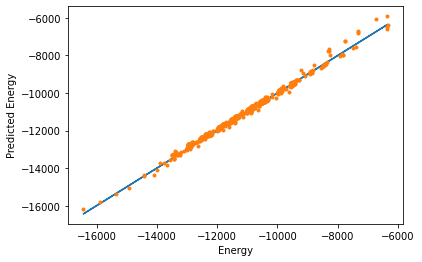

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


ys = []
yhats = []
for v in validation_set:
    (e, x), y = convert_record(v)
    ys.append(y)
    # yhat_raw = Model(e, x, w1, w2, w3, b)
    model = Model(w1, w2, w3, b, graph_feature_len)
    model.eval()
    yhat_raw = model(e, x)
    
    yhats.append(transform_prediction(yhat_raw))


yhats1 = []
for i in yhats:
    i = i.detach().numpy()
    yhats1.append(i)

print("ys: ", ys)
print("yhats: ", yhats)

mse = np.sqrt(mean_absolute_error(ys, yhats1))
print(f'MSE: {mse}')

rmse = np.sqrt(mean_squared_error(ys, yhats1))
print(f'RMSE: {rmse}')

r2 = r2_score(ys, yhats1)
print("R-squared (R2) Score:", r2)


plt.plot(ys, ys, "-")
plt.plot(ys, yhats1, ".")
plt.xlabel("Energy")
plt.ylabel("Predicted Energy")
# plt.show()

